<a href="https://colab.research.google.com/github/daleas0120/Example_notebooks/blob/main/Loss_Landscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Loss Landscape Visualizations
---

Curious to see if I can take a neural network, train it, and then run it backwards.
[link text](https://)

In [32]:
!pip install torchinfo

In [33]:
!pip install torcheval

In [ ]:
! pip install loss-landscapes

In [56]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchinfo import summary
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torcheval.metrics.functional import multiclass_f1_score
import copy
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

In [35]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size_train = 8
batch_size_test = 8

# 0. Load Data


In [36]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=False)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=False)

## Create Custom, Random Dataset

In [37]:
rand_img = torch.rand(1, 28, 28, requires_grad=True)

# 1. Define Model

In [38]:
class CNN_classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN_classifier, self).__init__()
        self.conv0 = nn.Conv2d(1, 4, (3, 3), stride=2)
        self.conv1 = nn.Conv2d(4, 8, (3,3), stride=2)
        self.conv2 = nn.Conv2d(8, 16, (3,3), stride=2)
        self.flat = nn.Flatten(start_dim=1, end_dim=-1)
        self.linear = nn.Linear(64, num_classes)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.num_classes = num_classes

    def forward(self, input):
        c0 = F.relu(self.conv0(input))
        c1 = F.relu(self.conv1(c0))
        c2 = F.relu(self.conv2(c1))
        c2_flat = self.flat(c2)
        feat_vec = self.linear(c2_flat)
        logits = F.softmax(feat_vec, dim=1)

        return logits


In [39]:
classifier_model = CNN_classifier(input_dim=(1, 28, 28), num_classes=10).to(DEVICE)

In [40]:
summary(classifier_model, (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_classifier                           [1, 10]                   --
├─Conv2d: 1-1                            [1, 4, 13, 13]            40
├─Conv2d: 1-2                            [1, 8, 6, 6]              296
├─Conv2d: 1-3                            [1, 16, 2, 2]             1,168
├─Flatten: 1-4                           [1, 64]                   --
├─Linear: 1-5                            [1, 10]                   650
Total params: 2,154
Trainable params: 2,154
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

# 2. Prepare for Training

In [41]:
learning_rate = 1e-5
num_epochs = 5
MSE_loss = nn.MSELoss()

In [42]:
from torch.optim import LBFGS, Adam

BCE_loss = nn.BCELoss()
MSE_loss = nn.MSELoss()

def loss_function(x, x_hat, mean, log_var, recon_const=1.):
    #reconstruction_loss = recon_const*nn.functional.binary_cross_entropy(x_hat, x, reduction='sum',)
    reconstruction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + KLD, reconstruction_loss, KLD


optimizer = Adam(classifier_model.parameters(), lr=learning_rate)
#optimizer = optim.LBFGS([rand_img])
loss = nn.MSELoss()

# 3. Training

In [43]:
model_initial = copy.deepcopy(classifier_model)

In [44]:
for epoch in range(num_epochs):

    for batch_idx, (x, Y) in enumerate(tqdm(train_loader, desc="Training Epoch "+str(epoch))):

        x = x.to(DEVICE)

        one_hot = F.one_hot(Y, num_classes=10)

        label = torch.tensor(one_hot, dtype=torch.float).to(DEVICE)

        optimizer.zero_grad()

        logits = classifier_model(x)

        loss = MSE_loss(label, logits)

        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.6f}'.format(epoch+1, num_epochs, loss.item()))


Training Epoch 0:   0%|          | 0/7500 [00:00<?, ?it/s]<ipython-input-44-ff3af4e9ca6f>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(one_hot, dtype=torch.float).to(DEVICE)
Training Epoch 0: 100%|██████████| 7500/7500 [00:58<00:00, 127.57it/s]


Epoch [1/5], Loss: 0.087151


Training Epoch 1: 100%|██████████| 7500/7500 [00:49<00:00, 151.72it/s]


Epoch [2/5], Loss: 0.056259


Training Epoch 2: 100%|██████████| 7500/7500 [00:50<00:00, 147.14it/s]


Epoch [3/5], Loss: 0.031889


Training Epoch 3: 100%|██████████| 7500/7500 [00:50<00:00, 147.46it/s]


Epoch [4/5], Loss: 0.024411


Training Epoch 4: 100%|██████████| 7500/7500 [00:49<00:00, 150.31it/s]

Epoch [5/5], Loss: 0.020966


In [45]:
model_final = copy.deepcopy(classifier_model)

# 4. Testing

In [46]:
labels_true = []
labels_pred = []

for batch_idx, (x, Y) in enumerate(tqdm(test_loader, desc="Testing ")):

        x = x.to(DEVICE)

        one_hot = F.one_hot(Y, num_classes=10)

        #label = torch.tensor(Y, dtype=torch.float).to(DEVICE)
        labels_true.extend(Y.detach().numpy())

        logits = classifier_model(x)
        labels_pred.extend(torch.argmax(logits, axis=1).detach().numpy())
        break



Testing :   0%|          | 0/1250 [00:00<?, ?it/s]


In [47]:
multiclass_f1_score(torch.tensor(labels_true), torch.tensor(labels_pred), num_classes=10, average=None)

tensor([1., 1., 1., 0., 1., 0., 0., 1., 0., 1.])

# 5. Loss Landscape

In [49]:
import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes import random_plane

In [61]:
STEPS=500

In [62]:
# data that the evaluator will use when evaluating loss
x, y = iter(train_loader).__next__()
x, y = x.to(DEVICE), y.to(DEVICE)
metric = loss_landscapes.metrics.Loss(MSE_loss, x, one_hot)

# compute loss data
loss_data = loss_landscapes.linear_interpolation(model_initial, model_final, metric, STEPS, deepcopy_model=True)


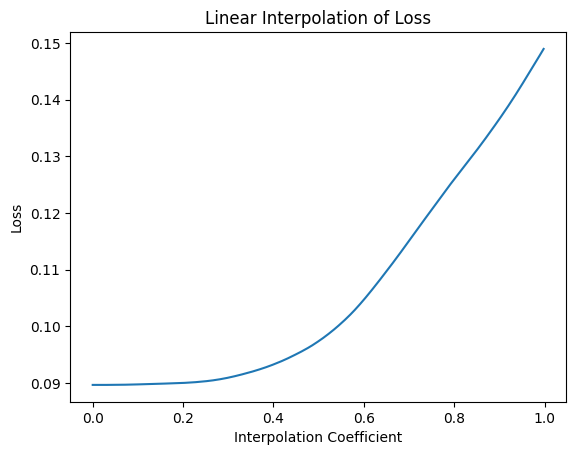

In [63]:
plt.plot([1/STEPS * i for i in range(STEPS)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()


In [64]:
loss_data_fin = loss_landscapes.random_plane(model_final, metric, 10, STEPS, normalization='filter', deepcopy_model=True)

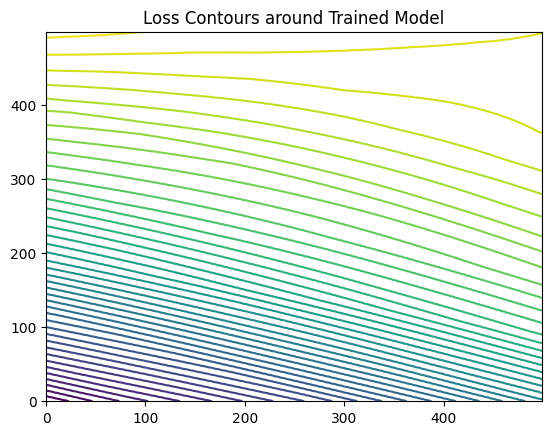

In [65]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

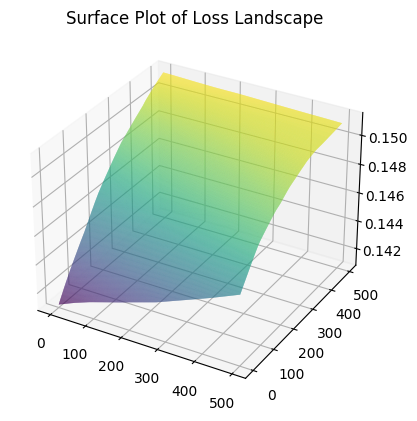

In [66]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()


# 6. Hessian

In [ ]:
from torch.func import functional_call, vmap, hessian

torch.autograd.functional.hessian(error_func, set of values)


In [ ]:
my_params = dict(classifier_model.named_parameters())

In [ ]:
my_params.keys()

In [ ]:
net = classifier_model

batch_size=8

targets = torch.randn(batch_size)
inputs = torch.randn(batch_size, 1)
params = dict(net.named_parameters())

def fcall(params, inputs):
  outputs = functional_call(net, params, inputs)
  return outputs

def loss_fn(outputs, targets):
  return torch.mean((outputs - targets)**2, dim=0)

def compute_loss(params, inputs, targets):
  #outputs = vmap(fcall, in_dims=(None,0))(params, inputs) #vectorize over batch
  outputs = net(inputs)
  return loss_fn(outputs, targets)

def compute_hessian_loss(params, inputs, targets):
  return hessian(compute_loss, argnums=(0))(params, inputs, targets)

loss = compute_loss(my_params, x, one_hot)
print(loss)

hess = compute_hessian_loss(my_params, x, one_hot)
key=list(params.keys())[-1] #take weight in first layer as example key
print(hess[key][key].shape) #Hessian of loss w.r.t first weight (shape [16, 1, 16, 1])

In [ ]:
one_hot[0].shape

In [ ]:
import torch
from torch import nn
from torch.func import functional_call, vmap, hessian

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.fc1=nn.Linear(1,16)
    self.fc2=nn.Linear(16,1)
    self.af=nn.Tanh()
  def forward(self, x):
    x=self.fc1(x)
    x=self.af(x)
    x=self.fc2(x)
    return x.squeeze(-1)

net = Model()

batch_size=1

targets = torch.randn(batch_size)
inputs = torch.randn(batch_size, 1)
params = dict(net.named_parameters())

def fcall(params, inputs):
  outputs = functional_call(net, params, inputs)
  return outputs

def loss_fn(outputs, targets):
  return torch.mean((outputs - targets)**2, dim=0)

def compute_loss(params, inputs, targets):
  outputs = vmap(fcall, in_dims=(None,0))(params, inputs) #vectorize over batch
  return loss_fn(outputs, targets)

def compute_hessian_loss(params, inputs, targets):
  return hessian(compute_loss, argnums=(0))(params, inputs, targets)

loss = compute_loss(params, inputs, targets)
print(loss)

hess = compute_hessian_loss(params, inputs, targets)
key=list(params.keys())[0] #take weight in first layer as example key
print(hess[key][key].shape) #Hessian of loss w.r.t first weight (shape [16, 1, 16, 1])

# Loss Landscape - Animation

In [ ]:
! pip install loss-landscape-anim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 731.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 50.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB